In [1]:
from climpyrical.gridding import find_nearest_index, find_element_wise_nearest_pos, scale_model_obs
from climpyrical.mask import gen_raster_mask_from_vector, gen_upper_archipelago_mask, stratify_coords
import climpyrical.spytialProcess as sp
from climpyrical.data import interpolate_dataset, gen_dataset
from climpyrical.rkrig import krigit_north, rkrig_r

from pkg_resources import resource_filename

from rpy2.robjects.packages import importr
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import NearestNDInterpolator
from sklearn.neighbors import NearestNeighbors
import pickle

from tqdm import tqdm
import dask.array as da
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib


from pykrige.ok import OrdinaryKriging

importr("fields")


%load_ext autoreload
%autoreload 2

In [2]:
with open('station_dv.pickle', 'rb') as outfile:
    station_dv = pickle.load(outfile)
    print("Pickled station dv: ", station_dv)

filenames = {
    'RL50 (kPa)': 'RL50',
    'mean RH (%)': 'RHann',
    'HDD (degC-day)': 'HDD',
    'SL50 (kPa)': 'SL50',
    'Q10_Gumbel-MM': 'WP10',
    'Q50_Gumbel-MM': 'WP50',
    'TJan2.5 (degC)': 'TJan2.5',
    'TJan1.0 (degC)': 'TJan1.0',
    'Tmin (degC)': 'Tmin',
    'Tmax (degC)': 'Tmax',
    'TJul2.5 (degC)': 'TJul97.5',
    'TwJul2.5 (degC)': 'TwJul97.5',
    'DRWP-RL5 (Pa)': 'DRWP5',
    'annual_pr (mm)': 'PAnn',
    'annual_rain (mm)': 'RAnn',
    'RL50 (mm)': 'R1d50'
}

file_dv = filenames[station_dv]

OLD_PATH = resource_filename(
    'climpyrical',
    'nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
)

dsold = xr.open_dataset(OLD_PATH)
dsold_max = dsold.rlat.values.max()

DS_PATH = resource_filename(
    'climpyrical',
    f'nrc_data/processed/{file_dv}_pre_processed.nc'
)

MASK_PATH = resource_filename(
    'climpyrical',
    'nrc_data/processed/canada_mask_rp.nc'
)

ds = xr.open_dataset(DS_PATH)
dv = list(ds.data_vars)[0]
mask = xr.open_dataset(MASK_PATH)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
orlon, orlat = np.meshgrid(dsold.rlon, dsold.rlat)

print(dv)

ds.lon.values

Pickled station dv:  Tmin (degC)
tas


array([[232.7803029 , 232.81612361, 232.85195491, ..., 293.14804509,
        293.18387639, 293.2196971 ],
       [232.76109367, 232.79693385, 232.83278463, ..., 293.16721537,
        293.20306615, 293.23890633],
       [232.74187878, 232.77773841, 232.81360867, ..., 293.18639133,
        293.22226159, 293.25812122],
       ...,
       [171.67374433, 171.70213964, 171.73056539, ..., 354.26943461,
        354.29786036, 354.32625567],
       [171.580915  , 171.60920277, 171.63752073, ..., 354.36247927,
        354.39079723, 354.419085  ],
       [171.48798164, 171.51616162, 171.54437153, ..., 354.45562847,
        354.48383838, 354.51201836]])

In [3]:
df_path = resource_filename('climpyrical', f'nrc_data/processed/{file_dv}_processed_station.csv')

df = pd.read_csv(df_path, index_col=False)

df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

In [4]:
alert_rlon, alert_rlat = 5.279164, 36.203886
alert_lon, alert_lat = -62.3333, 82.5

In [5]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

# Krig the station only values in the north

In [6]:
path_shapefile = resource_filename('climpyrical', 'nrc_data/canada_final.shp')
canada = gpd.read_file(path_shapefile).geometry
northern_mask = gen_upper_archipelago_mask(canada, ds.rlon.values, ds.rlat.values, 210, dsold_max)

# dummy array to force 14 nearest stations to Alert 
alert_arr = [[1472, 894, 235.85, 36.20388623771783, 5.279164142263307,
        82.5, -62.3333, 'ALERT CLIMATE', 1.0091788499249528,
        234.48550962410286]]

alert_cond = (np.any(df.station_name.str.contains('ALERT')) or 
                np.any(df.station_name.str.contains('alert')))

temp_infill = True
if temp_infill:
    if np.any(df.rlat.values[alert_cond] > 36.0):
        print("Include ALERT")
        station_final_north_UAA = ~np.isnan(krigit_north(df, station_dv, 15, ds, extrap=False))

    else:
        # Add in the coords for alert
        print("No ALERT. Adding place holder.")
        df_cp = df.append(pd.DataFrame(alert_arr, columns=df.columns))
        station_final_north_UAA = ~np.isnan(krigit_north(df_cp, station_dv, 15, ds, extrap=False))
else:
    station_final_north = krigit_north(df, station_dv, 15, ds, extrap=True)
    station_final_north[~northern_mask] = np.nan

    north_nan = ~np.isnan(station_final_north)
    missed_station_only = (northern_mask^north_nan)

    station_final_north[~northern_mask] = np.nan

    f = NearestNDInterpolator(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])

    station_final_north_filled = station_final_north.copy()
    station_final_north_filled[missed_station_only] = f(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)
    station_final_north_filled[~northern_mask] = np.nan

UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])

100%|██████████| 59147/59147 [00:08<00:00, 6670.42it/s]


Include ALERT


## Find areas in north that are not covered by station only reconstruction

In [7]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

df['ilocy'] = iy 
df['ilocx'] = ix

In [8]:
# choose starting value
# model_vals = ds[dv].values[df.ilocy.values, df.ilocx.values]
model_vals = df.model_vals.values
station_vals = df[station_dv].values

ratio, best_tol = scale_model_obs(df.model_vals, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

print(best_tol)

0.996781877025386


In [9]:
np.seterr(divide='ignore', invalid='ignore')
ratio = rkrig_r(df_south, 30, ds, station_dv)
ratio[~mask] = np.nan

100%|██████████| 1273/1273 [19:38<00:00,  1.41s/it]


In [10]:
cxmin, cxmax, cymin, cymax = (
    canada.bounds.minx.min(),
    canada.bounds.maxx.max(),
    canada.bounds.miny.min(),
    canada.bounds.maxy.max()
)

<AxesSubplot:ylabel='Count'>

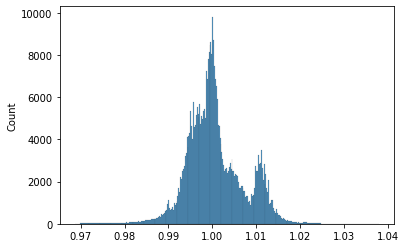

In [11]:
import seaborn as sns
sns.histplot(ratio[~np.isnan(ratio)])

In [38]:
X, Y = stratify_coords(canada)
X

array([-8.493926736418855, -8.702274668967323, -8.978055691981433, ...,
       -15.040090550649854, -15.101311036873057, None], dtype=object)

In [39]:
!pwd

/home/nannau/11062020/climpyrical/notebooks/dev


In [13]:
extent = [ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()]

# ratio = np.array(ratio, dtype=np.float)

# fig, ax = plt.subplots(figsize=(25, 25))

# # vmax = np.nanmax(df[station_dv].values)
# # vmin = np.nanmin(df[station_dv].values)
# # vmin = 5
# vmin = 0
# vmax = 3


# N = 15
# cont = np.arange(vmin, vmax, 1)

# col1 = ax.imshow(selection, origin='lower', vmin=vmin, vmax=vmax, extent=extent, cmap = plt.cm.get_cmap("viridis", N))
# CS = ax.contour(ds.rlon, ds.rlat, ratio, cont, colors='black', linewidths=1, zorder=4)
# plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

# ax.set_xlim(cxmin-1, cxmax+1)
# ax.set_ylim(cymin-1, cymax+1)
# ax.clabel(CS, fontsize=18, inline=1)
# ax.set_title(station_dv+' Standardized')
# canada.plot(ax=ax, color='red', zorder=0)
# ax.plot(X, Y, color='black')

# # plt.savefig(f'./data/plots/standardized-{station_dv}-Z-full-reconstruction-patched.png')
# plt.savefig('/home/nannau/Desktop/sample_band')

In [14]:
nanmask = ~np.isnan(ratio)
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
ratio_final = ratio.copy()
points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_values = ratio[nanmask]
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

ratio_final[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')

rfcp = ratio_final.copy()
rfcp[northern_mask] = np.nan
ratio_final = ratio_final*mean_corrected.copy()

meancopynorth = ds[dv].values.copy()
meancopynorth[northern_mask] = np.nan

ratio_final_sample_mask = np.logical_and(station_final_north_UAA, ~np.isnan(meancopynorth))
ratio_final_mean_overlap_area = np.nanmean(ratio_final[ratio_final_sample_mask])

combined_ratio_station_mean = np.mean([ratio_final_mean_overlap_area, UAA_station_mean])

# lon_cond = np.logical_and(((dsold.lon.values - 360) > -125), ((dsold.lon.values -  360) < -75))

# latarr = dsold.lat.values.flatten()
# lonarr = dsold.lon.values.flatten()

# points = np.stack([orlon.flatten(), orlat.flatten()]).T
# target_points = np.stack([rlon.flatten(), rlat.flatten()]).T

# lat_10 = interpolate_dataset(points, latarr, target_points, method='linear').reshape(ds[dv].shape)
# lon_10 = interpolate_dataset(points, lonarr, target_points, method='linear').reshape(ds[dv].shape)

# latds = gen_dataset('lat', lat_10, ds.rlat.values, ds.rlon.values, ds.rlat, ds.rlon)
# londs = gen_dataset('lon', lon_10, ds.rlat.values, ds.rlon.values, ds.rlat, ds.rlon)

selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

# Create a final field
temp_infill=False
if temp_infill: 
    if 'RL50' in station_dv:
        print("North = 0.0")
        ratio_final[northern_mask] = 0.0    
    else:
        print("North = mean of overlap")
        ratio_final[northern_mask] = combined_ratio_station_mean
        
else:
#     ratio_final[northern_mask] = station_final_north_filled[northern_mask]
    ratio_final[northern_mask] = np.mean([UAA_station_mean, np.nanmean(ratio_final[selection])])
    

if 'degC' in station_dv and not 'degC-day' in station_dv:
    print("subtracted!")
    print("Northern region:", combined_ratio_station_mean - 273.15)
    ratio_final -= 273.15
    df[station_dv] = df[station_dv] - 273.15

print(combined_ratio_station_mean-273.15, np.mean(ratio_final[northern_mask]))

subtracted!
Northern region: -45.339899624994075
-45.339899624994075 -45.233785070955705


array([[232.7803029 , 232.81612361, 232.85195491, ..., 293.14804509,
        293.18387639, 293.2196971 ],
       [232.76109367, 232.79693385, 232.83278463, ..., 293.16721537,
        293.20306615, 293.23890633],
       [232.74187878, 232.77773841, 232.81360867, ..., 293.18639133,
        293.22226159, 293.25812122],
       ...,
       [171.67374433, 171.70213964, 171.73056539, ..., 354.26943461,
        354.29786036, 354.32625567],
       [171.580915  , 171.60920277, 171.63752073, ..., 354.36247927,
        354.39079723, 354.419085  ],
       [171.48798164, 171.51616162, 171.54437153, ..., 354.45562847,
        354.48383838, 354.51201836]])

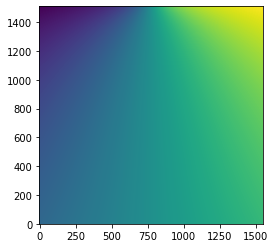

In [15]:
# selection
# plt.imshow(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -125)))
plt.imshow(ds.lon, origin='lower')
ds.lon.values#- 360 < -75)

No handles with labels found to put in legend.


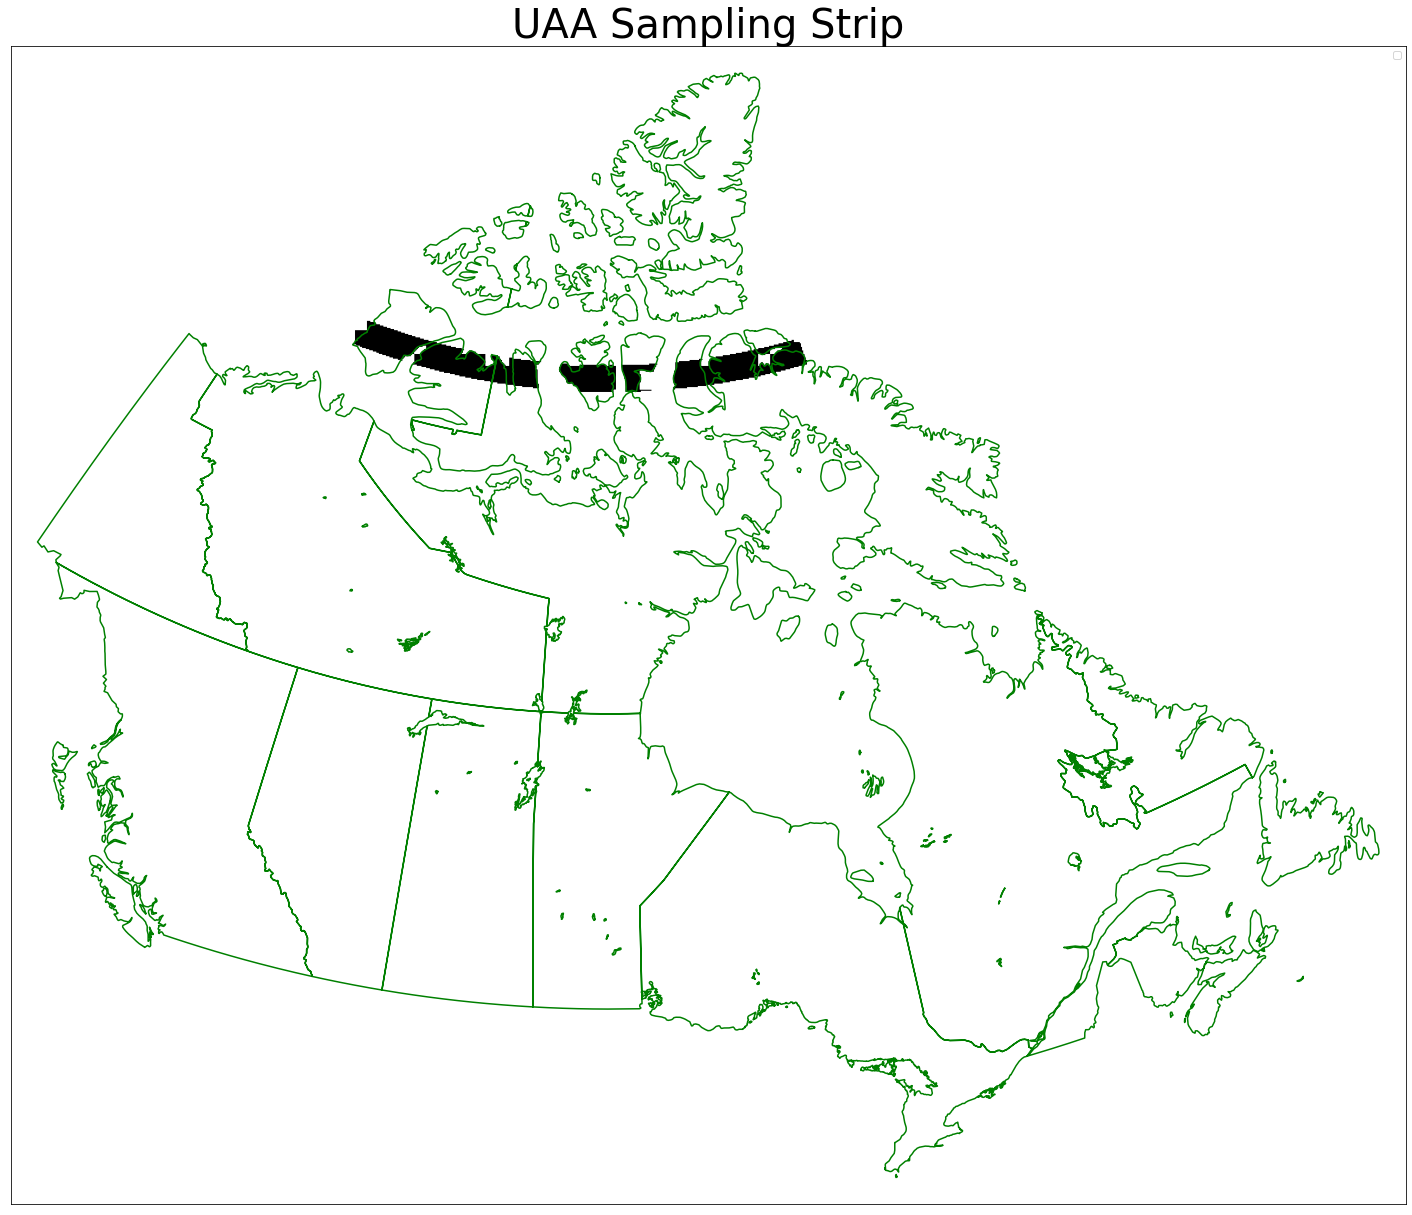

In [16]:
# New UAA determination
fig, ax = plt.subplots(figsize=(25, 25))
ax.imshow(selection, origin='lower', extent=extent, label='Strip', cmap = 'Greys')

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('UAA Sampling Strip', fontsize=40)
ax.plot(X, Y, color='green')
ax.legend()
plt.savefig(f'./data/reporting/sample_strip.png')
plt.show()

In [28]:
from climpyrical.data import gen_dataset
import matplotlib

recon_ds = gen_dataset(dv, ratio_final, ds.rlat, ds.rlon, ds.lat, ds.lon)
recon_ds.to_netcdf(f'~/dash-dv-explorer/assets/data/reconstructions/{file_dv}_reconstruction.nc')

In [32]:
recon_ds.lon

<xarray.DataArray 'lon' (rlat: 1510, rlon: 1550)>
array([[232.7803029 , 232.81612361, 232.85195491, ..., 293.14804509,
        293.18387639, 293.2196971 ],
       [232.76109367, 232.79693385, 232.83278463, ..., 293.16721537,
        293.20306615, 293.23890633],
       [232.74187878, 232.77773841, 232.81360867, ..., 293.18639133,
        293.22226159, 293.25812122],
       ...,
       [171.67374433, 171.70213964, 171.73056539, ..., 354.26943461,
        354.29786036, 354.32625567],
       [171.580915  , 171.60920277, 171.63752073, ..., 354.36247927,
        354.39079723, 354.419085  ],
       [171.48798164, 171.51616162, 171.54437153, ..., 354.45562847,
        354.48383838, 354.51201836]])
Coordinates:
    lat      (rlat, rlon) float64 11.85 11.87 11.88 11.9 ... 63.66 63.62 63.59
    lon      (rlat, rlon) float64 232.8 232.8 232.9 232.9 ... 354.5 354.5 354.5
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86

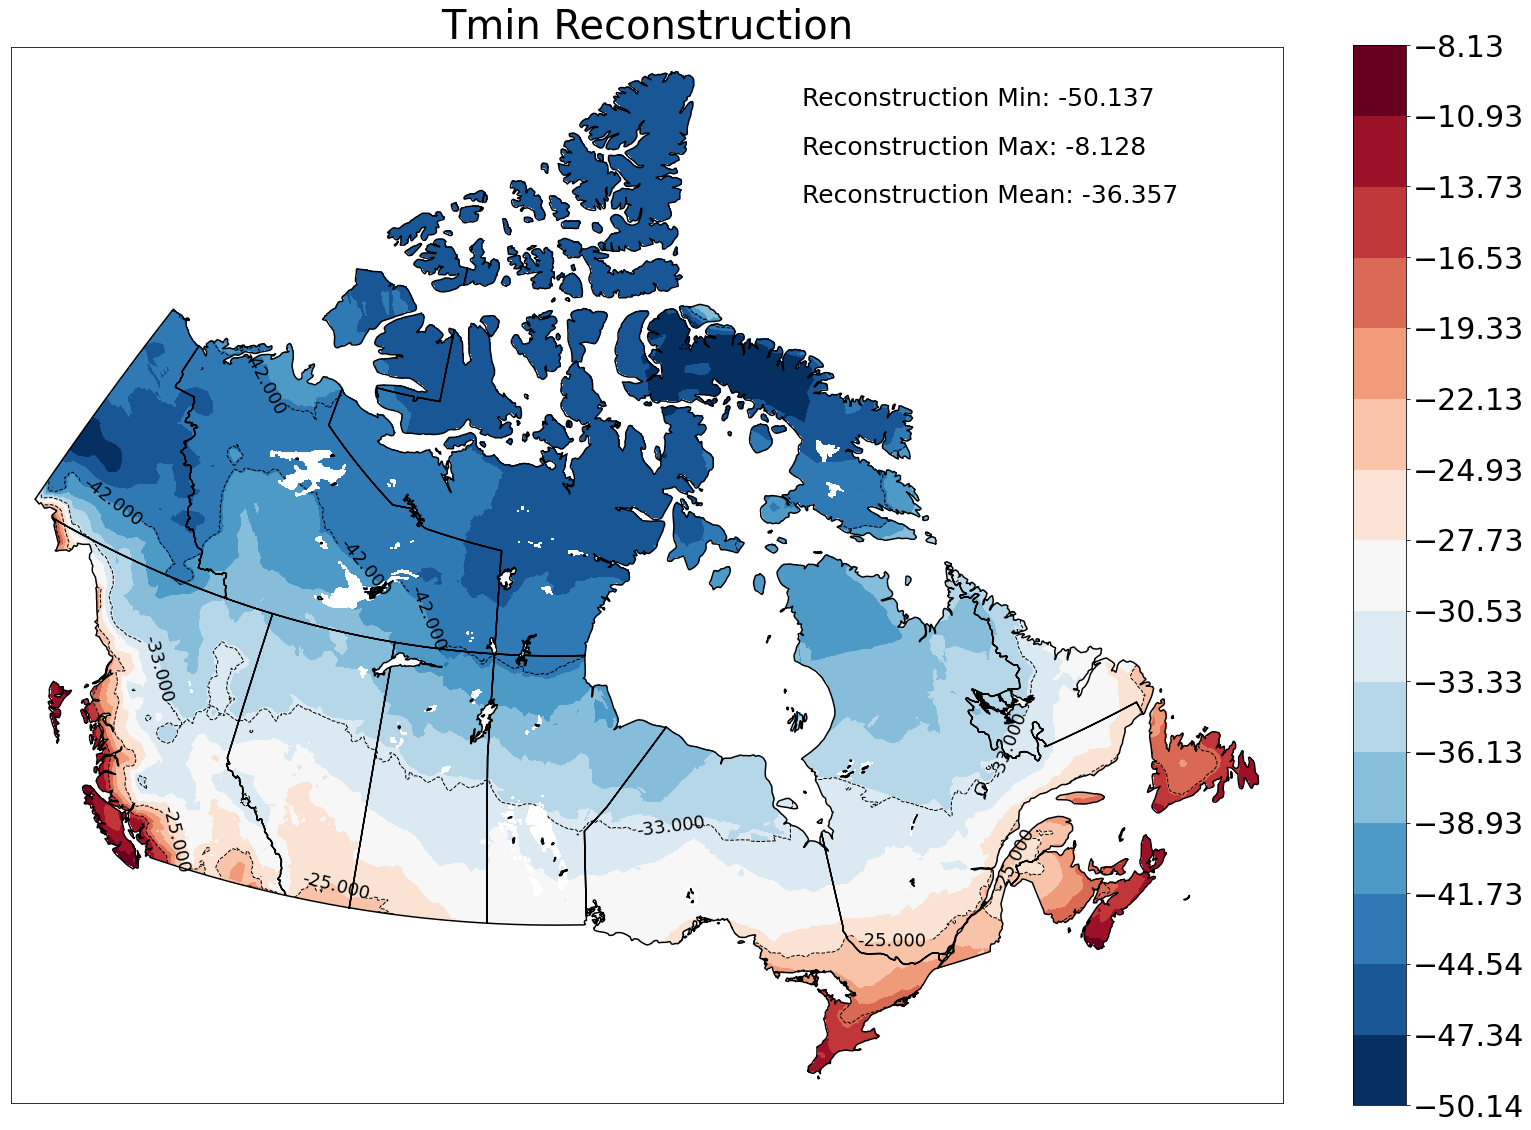

In [18]:
plot_dict = {
    'RL50 (kPa)': (0, 1.2, 12, 0.1),
    'mean RH (%)': (50, 100, 10, 5),
    'HDD (degC-day)': (1000, 15000, 15, 1000),
    'SL50 (kPa)': (0, 15, 15, 1),
    'Q10_Gumbel-MM': (0, 0.8, 8, 0.1),
    'Q50_Gumbel-MM': (0, 1.2, 12, 0.1),
    'TJan2.5 (degC)': (-50, 10, 12, 6),
    'TJan1.0 (degC)': (-50, 10, 12, 6),
    'Tmin (degC)': (-50, 10, 15, 6),
    'Tmax (degC)': (0, 50, 15, 6),
    'TJul2.5 (degC)': (0, 50, 15, 6),
    'TwJul2.5 (degC)': (0, 50, 15, 6),
    'annual_rain (mm)': (0, 150, 15, 500),
    'annual_pr (mm)': (0, 150, 15, 500),
    'DRWP-RL5 (Pa)': (0, 10, 10, 50),
    'RL50 (mm)': (0, 10, 10, 50)
}

vmin, vmax, N, n_cont = plot_dict[station_dv]
vmin, vmax = np.nanmin(ratio_final), np.nanmax(ratio_final)

cont = np.round(np.linspace(vmin, vmax, n_cont), decimals=0)
tick_cols = np.linspace(vmin, vmax, N+1)

fig, ax = plt.subplots(figsize=(25, 25))

colorscale = 'gist_earth_r'
lmap = ['#505459', '#515B61', '#51666A', '#517371', '#507C70', '#4F856A', '#4A8A4D','#629044', '#87953F', '#9B7F39', '#A05134']
lmap = ['#804E80'
, '#68578D'
, '#61789B'
, '#6AA8A2'
, '#66AC8E'
, '#61B173'
, '#67B55D'
, '#84BA58'
, '#A8BE54'
, '#C3B44F'
, '#C78E4B']

#35658D
#458298
#569BA1
#6AA8A2
#66AC8E
#61B173
#67B55D
#84BA58
#A8BE54
#C3B44F
#C78E4B
lmap = [
'#B544A6',
'#884DB2',
'#5856AF',
'#6089AC',
'#6AA8A2',
'#64AE84',
'#62B07A',
'#75B85B',
'#B1BF53',
'#C78E4B',
]

colorscale = matplotlib.colors.ListedColormap(lmap[::-1])
colorscale='RdBu_r'



ax.text(10, 35, 'Reconstruction Min: {}'.format(np.round(np.nanmin(ratio_final), 3)), fontsize=25)
ax.text(10, 33, 'Reconstruction Max: {}'.format(np.round(np.nanmax(ratio_final), 3)), fontsize=25)
ax.text(10, 31, 'Reconstruction Mean: {}'.format(np.round(np.nanmean(ratio_final), 3)), fontsize=25)

col1 = ax.imshow(
    ratio_final, 
    origin='lower', 
    extent=extent, 
    vmin=vmin, 
    vmax=vmax, 
    cmap = matplotlib.cm.get_cmap(colorscale, N))

CS = ax.contour(ds.rlon, ds.rlat, ratio_final, cont, colors='black', linewidths=1, zorder=4)
cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks = tick_cols)
cbar.ax.tick_params(labelsize=30)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)


# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(file_dv+f' Reconstruction', fontsize=40)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}_reconstruction.png')
plt.show()

subtracted!


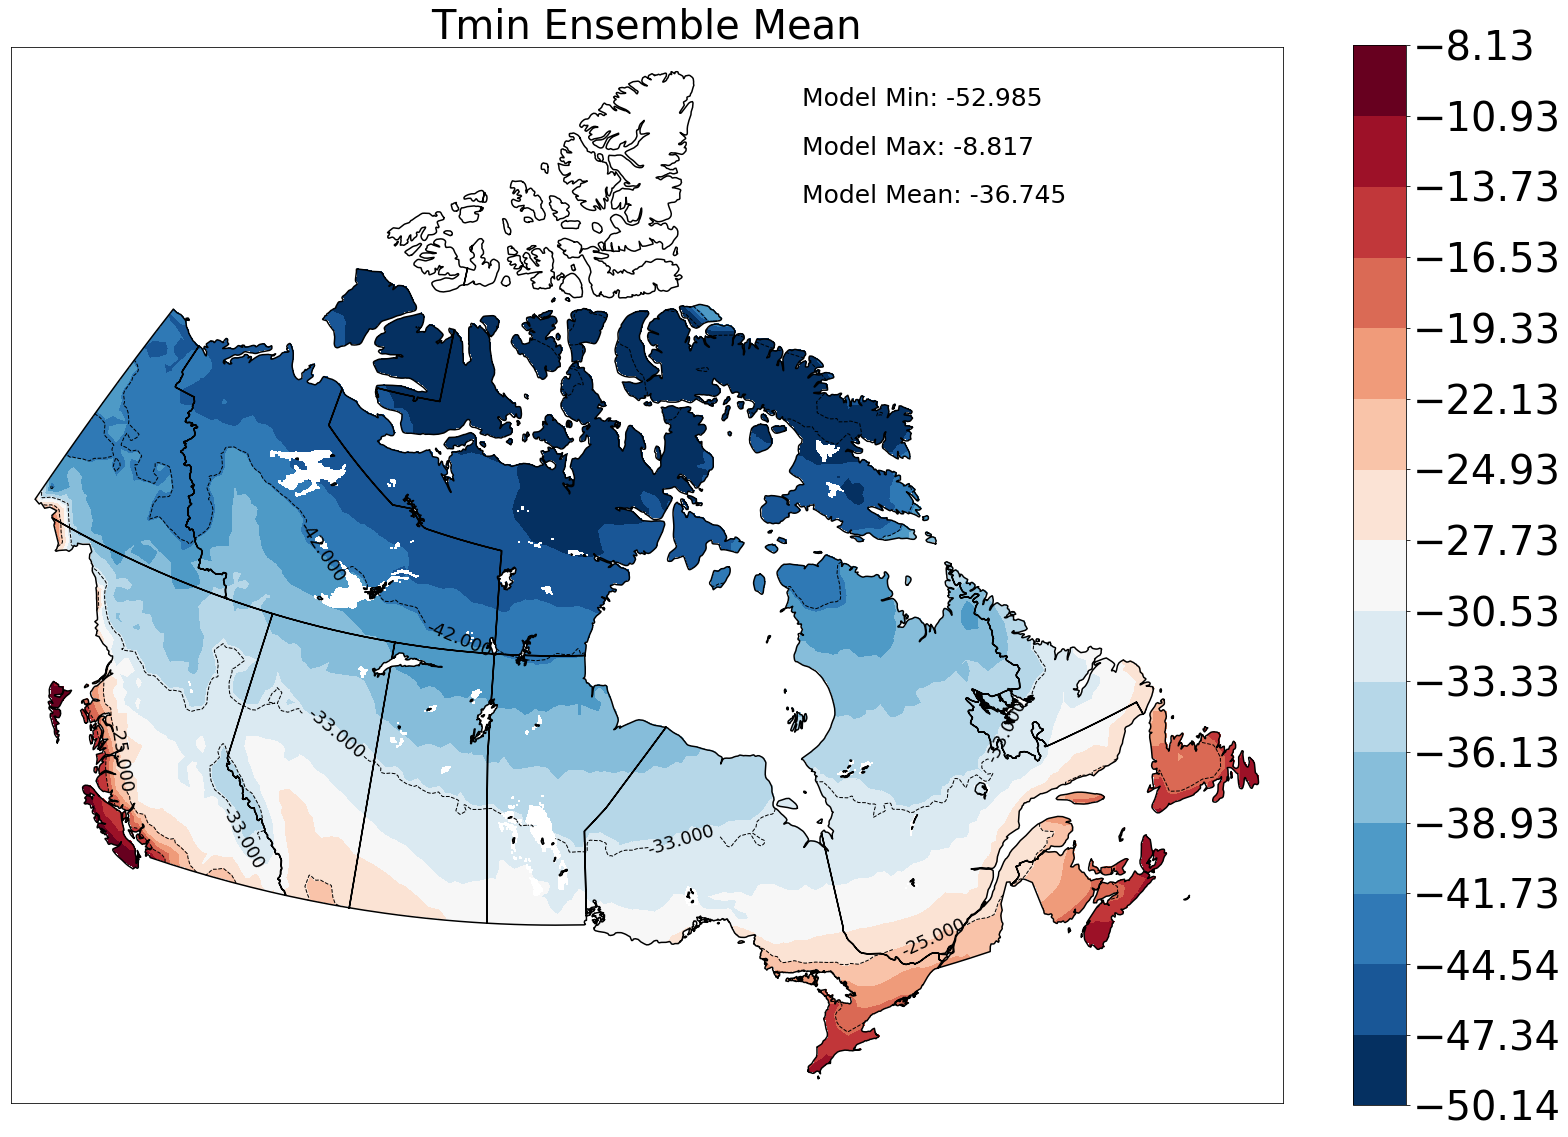

In [19]:
mean = ds[dv].values.copy()
mean[~mask] = np.nan
mean[northern_mask] = np.nan

if 'degC' in station_dv and not 'degC-day' in station_dv:
    print("subtracted!")
    mean -= 273.15
    

fig, ax = plt.subplots(figsize=(25, 25))

col1 = ax.imshow(mean, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap(colorscale, N))
CS = ax.contour(ds.rlon, ds.rlat, mean, cont, colors='black', linewidths=1, zorder=4)
cbar = plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05, ticks = tick_cols)

ax.text(10, 35, 'Model Min: {}'.format(np.round(np.nanmin(mean), 3)), fontsize=25)
ax.text(10, 33, 'Model Max: {}'.format(np.round(np.nanmax(mean), 3)), fontsize=25)
ax.text(10, 31, 'Model Mean: {}'.format(np.round(np.nanmean(mean), 3)), fontsize=25)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

cbar.ax.tick_params(labelsize=40)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(file_dv+' Ensemble Mean', fontsize=40)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}_CanRCM4_ensmean.png')
plt.show()

In [20]:
np.nanmean(ratio_final[selection])

-46.134236808578066

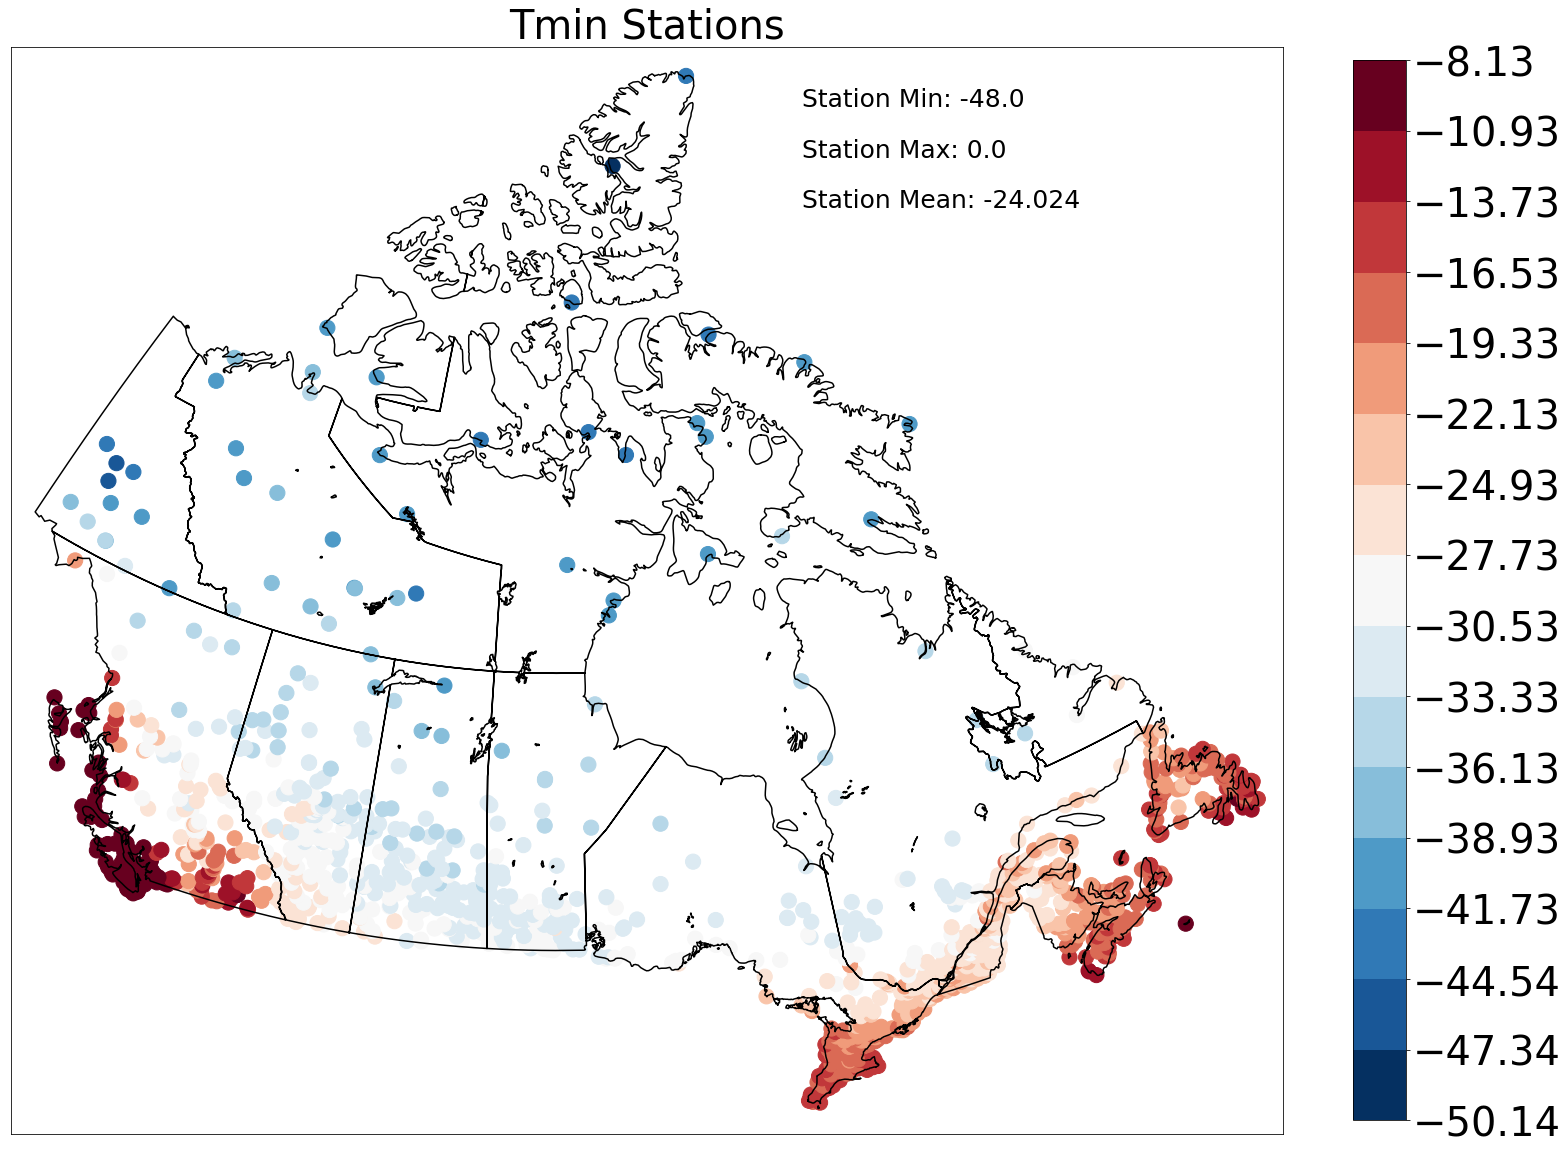

In [21]:
fig, ax = plt.subplots(figsize=(25, 20))

station_vals_deg_c = df[station_dv]

sc = ax.scatter(df.rlon, df.rlat, c = station_vals_deg_c, s=230, vmin = vmin, vmax = vmax, cmap = plt.cm.get_cmap(colorscale, N))
cbar = plt.colorbar(sc, ax = ax, fraction=0.038, pad=0.05, ticks = tick_cols)
cbar.ax.tick_params(labelsize=40)

ax.text(10, 35, 'Station Min: {}'.format(np.round(np.min(station_vals_deg_c), 3)), fontsize=25)
ax.text(10, 33, 'Station Max: {}'.format(np.max(station_vals_deg_c)), fontsize=25)
ax.text(10, 31, 'Station Mean: {}'.format(np.round(np.nanmean(station_vals_deg_c), 3)), fontsize=25)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

ax.set_title(file_dv+' Stations', fontsize=40)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}_stations.png')

In [22]:
np.any(mean[mean < 0 ]), np.any(ratio_final[ratio_final < 0 ])

(True, True)

# Write to Table C-2


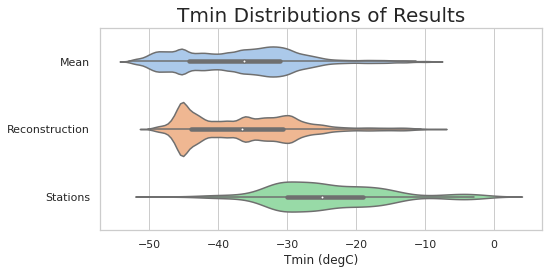

In [23]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(7, 3.5))

violindata = np.concatenate([mean.flatten(), ratio_final.flatten(), station_vals_deg_c])

means_str = ["Mean" for x in mean.flatten()]
ratio_str = ["Reconstruction" for x in ratio_final.flatten()]
station_str = ["Stations" for x in station_vals_deg_c]

vstrings = np.concatenate([means_str, ratio_str, station_str])

vdf = pd.DataFrame({station_dv: violindata, '': vstrings})
plt.tight_layout()

ax.set_title(f"{file_dv} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x=station_dv, y='', data=vdf, palette=sns.color_palette('pastel'))

plt.savefig(f'./data/reporting/{file_dv}_violin.png', bbox_inches='tight')

In [24]:
matched_df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

nrc_nan_df = matched_df_nrc[np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])]

ratio_nan = ~np.isnan(ratio_final)
    
f = NearestNDInterpolator(np.stack([rlon[ratio_nan], rlat[ratio_nan]]).T, ratio_final[ratio_nan])

table_nan = f(
    np.stack(
        [rlon[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values], 
         rlat[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values]
        ]).T).T

design_value = ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx]
dvnan = np.isnan(design_value)
design_value[dvnan] = table_nan

nrc_table = pd.DataFrame()
nrc_table[station_dv] = design_value
nrc_table = nrc_table.assign(
    Prov=matched_df_nrc.Prov,
    Location=matched_df_nrc.Location, 
    lat=matched_df_nrc.lat, 
    lon=matched_df_nrc.lon,
    rlat=matched_df_nrc.rlat, 
    rlon=matched_df_nrc.rlon)

assert not df.isnull().values.any()

nrc_table.round(3).to_csv("./data/reporting/"+file_dv+"_TableC2.csv", index=False)
nrc_table.round(3).to_csv("~/dash-dv-explorer/assets/data/tables/"+file_dv+"_TableC2.csv", index=False)

In [25]:
nrc_table

,Tmin (degC),Prov,Location,lat,lon,rlat,rlon
0,-30.709990,BC,100 Mile House,51.64,-121.30,6.472805,-14.893575
1,-14.770366,BC,Abbotsford,49.05,-122.33,4.215381,-16.329523
2,-17.621420,BC,Agassiz,49.24,-121.76,4.279140,-15.914789
3,-13.218205,BC,Alberni,49.27,-124.80,4.957228,-17.785699
4,-28.847827,BC,Ashcroft,50.72,-121.28,5.592810,-15.163711
...,...,...,...,...,...,...,...
674,-43.332337,NU,Kugluktuk,67.83,-115.10,21.173542,-7.222514
675,-39.702504,NU,Nottingham Island,63.12,-77.93,16.711316,8.872319
676,-45.233785,NU,Resolute,74.70,-94.83,27.208988,0.643710
677,-36.171382,NU,Resolution Island,61.31,-64.87,17.032368,15.487842


In [26]:
# !pwd
# !source upload_files.sh